In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.data.gamma.structural_pubmed import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.structural_omega.graph_sage import StructuralOmegaGraphSageCosSim

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename='logs/omega_function/pubmed/04-1-structural_graphsage_dotmlp_gamma_function.log'
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [6]:
dataset = load_dataset()

In [7]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)

In [8]:
data = prepare_adjencency(data)

## Training

In [10]:
for run in range(10):
    for n_layers_graph_sage in range(1, 4):
        omega = StructuralOmegaGraphSageCosSim(
            device,
            dataset='pubmed',
            in_channels=data.x.shape[1],
            n_layers_graph_sage=n_layers_graph_sage,
            run=run)
        torch.cuda.empty_cache()
        omega.train(edges_train,
                    edges_val,
                    edges_test,
                    data.x,
                    data.y.reshape(-1, 1),
                    data.adj_t)

## Results

### For a Layer Number

In [12]:
n_layers_graph_sage = 2

In [13]:
metrics = StructuralOmegaGraphSageCosSim.read_metrics(
    n_layers_graph_sage=n_layers_graph_sage,
    dataset='pubmed')
print(metrics.shape)
metrics.head()

(510, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,0.516280,0.494964,0.503372,0.524849,0.537462,0.523697
1,0,100,0.249988,0.404768,0.405647,0.936900,0.775990,0.788309
2,0,200,0.196562,0.362662,0.382675,0.952017,0.832176,0.803523
3,0,300,0.161714,0.418169,0.402343,0.968065,0.785121,0.812300
4,0,400,0.133487,0.376046,0.420571,0.977071,0.833576,0.808562


### Sumarize metrics per epoch

In [14]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [15]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [16]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,0.517557,0.000965,0.496742,0.001283,0.504798,0.001130,0.534113,0.005833,0.530435,0.016728,0.552620,0.013052
100,0.260768,0.008430,0.395400,0.017791,0.395583,0.008847,0.932062,0.005249,0.800904,0.017685,0.798937,0.009477
200,0.207012,0.008730,0.392559,0.028536,0.393163,0.015463,0.945917,0.006448,0.805440,0.021316,0.803305,0.012248
300,0.175131,0.009171,0.405523,0.028029,0.399250,0.014870,0.954908,0.006686,0.805386,0.019993,0.814534,0.010623
400,0.153531,0.012325,0.430547,0.035278,0.408933,0.015184,0.963089,0.007576,0.797157,0.019755,0.815391,0.012784


In [17]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
4200,0.035644,0.006019,0.601931,0.073441,0.586725,0.036601,0.996350,0.001246,0.860914,0.017195,0.863231,0.009506
3400,0.038325,0.005390,0.556847,0.066835,0.582628,0.050608,0.995737,0.001182,0.860130,0.010328,0.859732,0.013274
4300,0.034192,0.006195,0.622151,0.057602,0.618544,0.050466,0.996684,0.001496,0.859821,0.011444,0.861003,0.010423
4100,0.036797,0.007236,0.605960,0.046304,0.596283,0.053610,0.996219,0.001310,0.859564,0.015523,0.864042,0.012189
4800,0.031210,0.005178,0.641535,0.108688,0.603664,0.035982,0.997332,0.000945,0.859219,0.014204,0.866956,0.007651


/tmp/ipykernel_949631/910677226.py:8: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_949631/910677226.py:9: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_949631/910677226.py:56: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavio

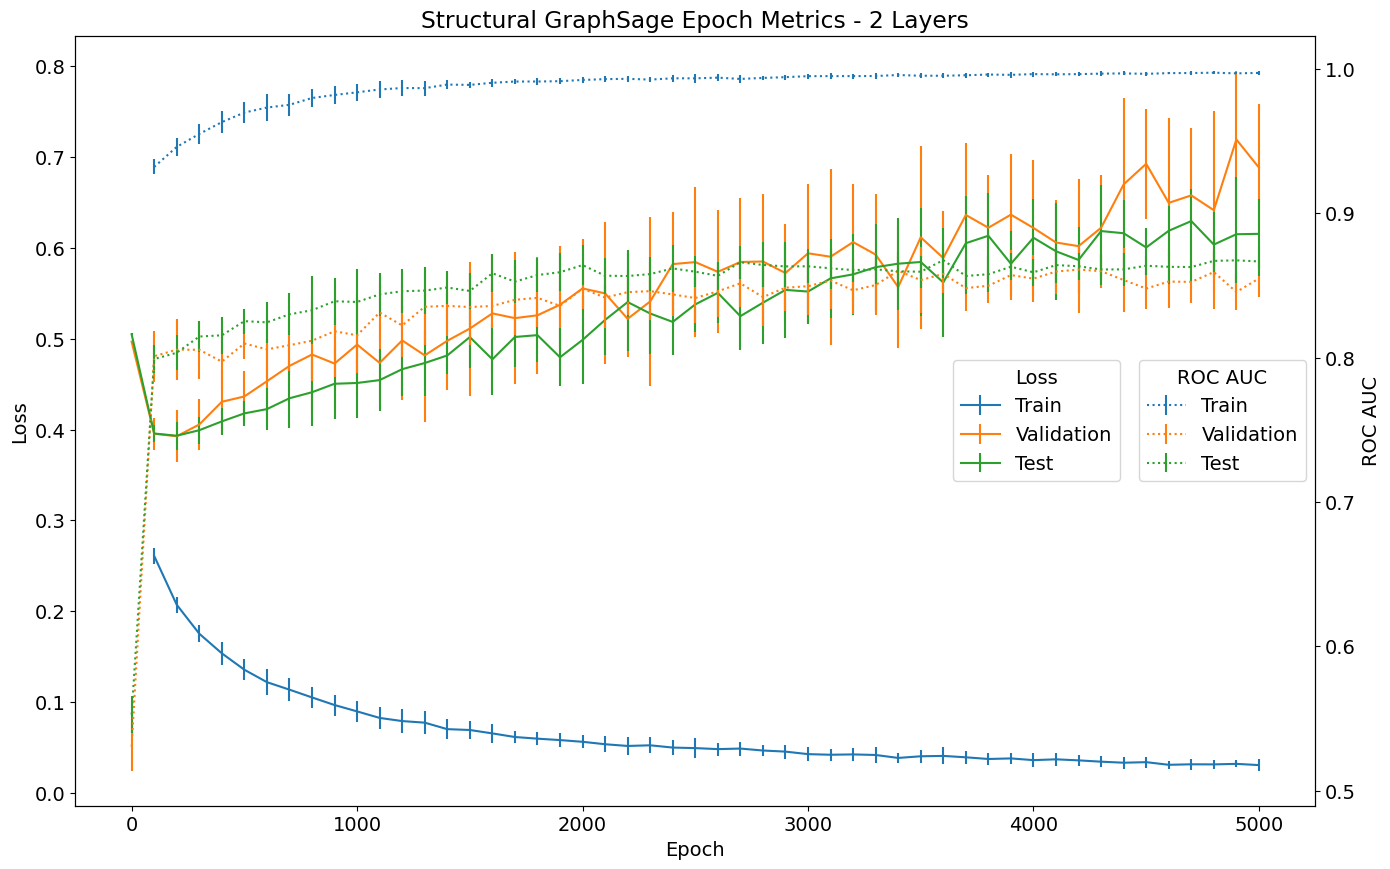

In [18]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title(f'Structural GraphSage Epoch Metrics - {n_layers_graph_sage} Layers')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

# ax1.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['loss_train_mean'][1:],
#     # yerr=epoch_metrics['loss_train_std'][1:],
#     ls='-',
#     label='Train')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_val_mean'],
#     # yerr=epoch_metrics['loss_val_std'],
#     ls='-',
#     label='Validation')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_test_mean'],
#     # yerr=epoch_metrics['loss_test_std'],
#     ls='-',
#     label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

# ax2.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['auc_train_mean'][1:],
#     # yerr=epoch_metrics['auc_train_std'][1:],
#     ls=':',
#     label='Train')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_val_mean'],
#     # yerr=epoch_metrics['auc_val_std'],
#     ls=':',
#     label='Validation')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_test_mean'],
#     # yerr=epoch_metrics['auc_test_std'],
#     ls=':',
#     label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

plt.savefig(f'reports/images/pubmed/structural_omega_graphsage_cossim_training_metrics_{n_layers_graph_sage}gslayers.pdf')

### Comparing Validation Performance for All Layer numbers

In [19]:
n_layers_list = range(1, 4)

In [20]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers_graph_sage in n_layers_list:
    metrics = StructuralOmegaGraphSageCosSim.read_metrics(dataset='pubmed', n_layers_graph_sage=n_layers_graph_sage)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers_graph_sage] = auc_val
    mean_loss_val_dict[n_layers_graph_sage] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers_graph_sage] = auc_val
    std_loss_val_dict[n_layers_graph_sage] = loss_val

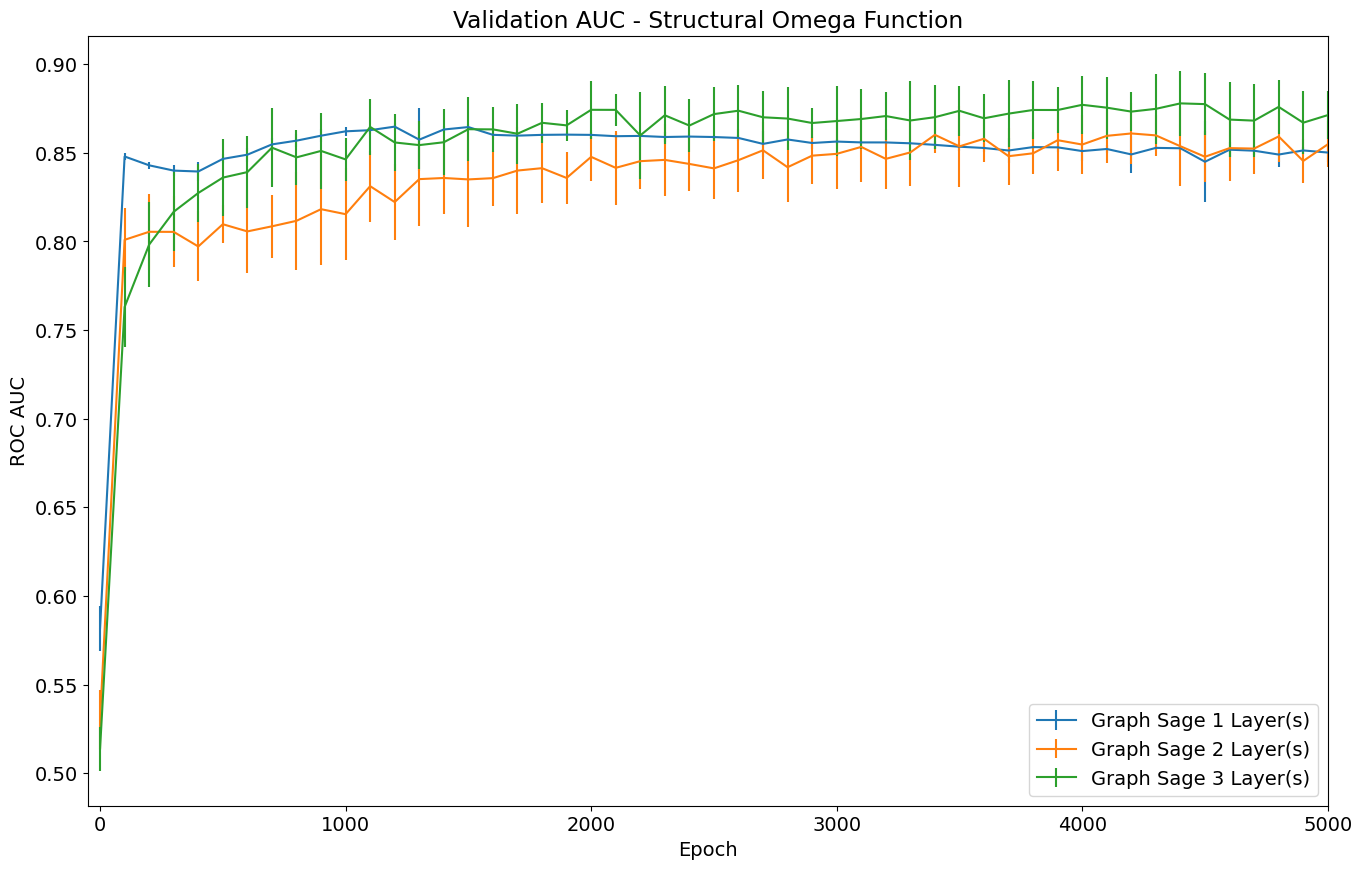

In [21]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Structural Omega Function')

for n_layers in mean_auc_val_dict:
    ax1.errorbar(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'Graph Sage {n_layers} Layer(s)')

ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

## Score Best model

In [22]:
n_layers_list = range(1, 4)

In [25]:
full_metrics = []
for n_layers_graph_sage in n_layers_list:
    metrics = StructuralOmegaGraphSageCosSim.read_metrics(
        dataset='pubmed',
        n_layers_graph_sage=n_layers_graph_sage)
    metrics['n_layers_graph_sage'] = n_layers_graph_sage
    full_metrics.append(metrics)
full_metrics = pd.concat(full_metrics)

In [26]:
best_model_metrics = full_metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

run                       0.000000
epoch                  4400.000000
loss_train                0.010146
loss_val                  0.509711
loss_test                 0.698029
auc_train                 0.999597
auc_val                   0.919355
auc_test                  0.867982
n_layers_graph_sage       3.000000
Name: 44, dtype: float64

In [28]:
best_model_metrics.to_json('models/structural_omega_grapn_sage_cossim/pubmed/best_model_info.json')